# TODO
# Clean AP_HI and AP_LO Dataset (Done)
# Convert Age from days to years (Done)
# Correlation between datas
# ML models

In [1]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb
sb.set() 

In [2]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [3]:
nRowsRead = None # specify 'None' if want to read whole file
# cardio_train.csv has 70000 rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('cardio_train.csv', delimiter=';', nrows = nRowsRead)
df1.dataframeName = 'cardio_train.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')
df1

There are 70000 rows and 13 columns


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [4]:
#cardio_csv = pd.read_csv('cardio_train.csv', sep=';')
#cardio_csv.shape

In [5]:
print("Data Type: ", type(df1))
print(df1.dtypes)

Data Type:  <class 'pandas.core.frame.DataFrame'>
id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object


# Convert age from days to years

In [6]:
df1['age'] = df1['age'].apply(lambda x: x/365).round(decimals = 0).astype(np.int64)
df1

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,53,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,62,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


# Clean AP_HI and AP_LO Dataset
## Drop AP_HI(Systolic blood pressure) and AP_LO row(Diastolic blood pressure) with < 0 value

In [7]:
indexap_hi = df1[df1['ap_hi'] < 0].index
indexap_lo = df1[df1['ap_lo'] < 0].index
#print(indexNames)
df1.drop(indexap_hi , inplace=True)
df1.drop(indexap_lo , inplace=True)
#df1 = df1.drop(df1[df1.ap_hi < 115].index)

In [8]:
df1

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,53,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,62,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


# Drop AP_HI(Systolic blood pressure) and AP_LO row(Diastolic blood pressure) that is way more/less than human threshold

### The threshold is determined by low blood pressure (AP_HI < 90mmHg or AP_LO < 60mmHG) and hypertensive crisis (AP_HI > 180mmHg or/and AP_LO > 120mmHG
#  It may be best to assume some AP_HI threshold between 75 to 200. Thus, rows that <75 and >200 are dropped

In [9]:
indexap_hi = df1[df1['ap_hi'] < 75].index
df1.drop(indexap_hi , inplace=True)
indexap_hi = df1[df1['ap_hi'] > 200].index
df1.drop(indexap_hi , inplace=True)

#df1.drop(indexap_lo , inplace=True)

In [46]:
#df1

#  It may be best to assume some AP_HI threshold between 45 to 140. Thus, rows that are <60 or >140 will be dropped

In [11]:
indexap_hi = df1[df1['ap_lo'] < 45].index
df1.drop(indexap_hi , inplace=True)
indexap_hi = df1[df1['ap_lo'] > 140].index
df1.drop(indexap_hi , inplace=True)

In [12]:
int64_items = pd.DataFrame(df1.select_dtypes(include = 'int64', exclude = None))
float64_items = pd.DataFrame(df1.select_dtypes(include = 'float64', exclude = None))

In [47]:
#df1

In [14]:
df1.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,68667.000000,68667.000000,68667.000000,68667.000000,68667.000000,68667.000000,68667.000000,68667.000000,68667.000000,68667.000000,68667.000000,68667.000000,68667.000000
mean,49976.184310,53.325251,1.348639,164.361178,74.113220,126.560546,81.328251,1.364396,1.225712,0.088004,0.053505,0.803428,0.494604
std,28846.711059,6.768238,0.476543,8.183950,14.323022,16.536729,9.451296,0.678788,0.571698,0.283303,0.225039,0.397409,0.499975
min,0.000000,30.000000,1.000000,55.000000,11.000000,80.000000,45.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25002.500000,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50012.000000,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74875.000000,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,65.000000,2.000000,250.000000,200.000000,200.000000,140.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
age = pd.DataFrame(int64_items["age"])
age.describe()

,age
count,68667.000000
mean,53.325251
std,6.768238
min,30.000000
25%,48.000000
50%,54.000000
75%,58.000000
max,65.000000


<AxesSubplot:>

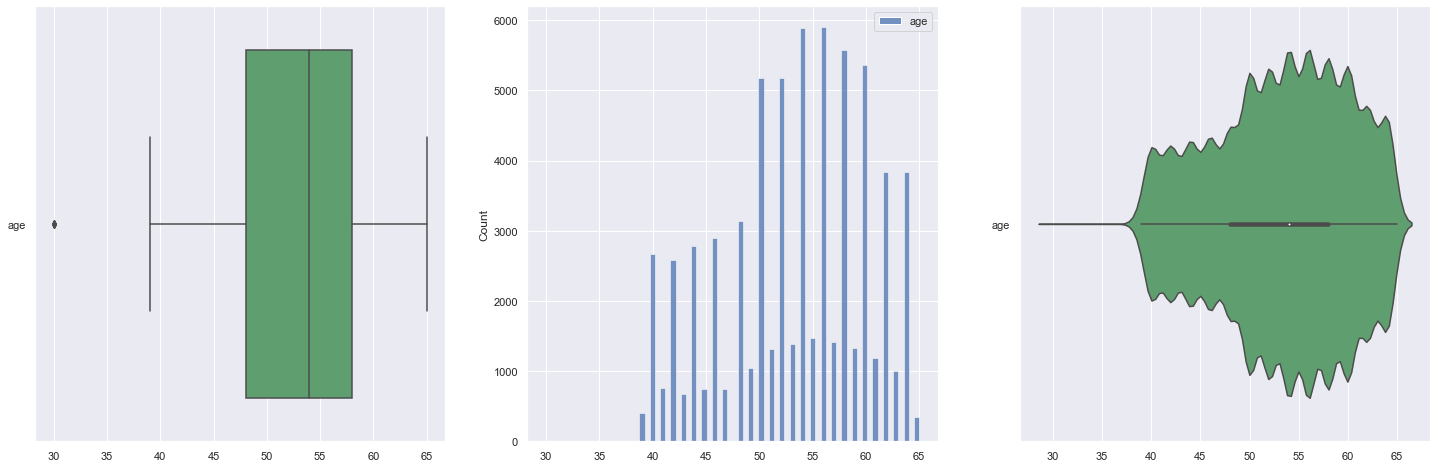

In [16]:
f, axes = plt.subplots(1, 3, figsize=(25, 8))
sb.boxplot(data = age, orient = "h", color = "g", ax = axes[0])
sb.histplot(data=age, color = "g", ax = axes[1])
sb.violinplot(data=age, orient='h', color = "g", ax = axes[2])

In [17]:
gender = pd.DataFrame(int64_items["gender"])
gender.describe()

,gender
count,68667.000000
mean,1.348639
std,0.476543
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


In [18]:
gender["gender"] = gender["gender"].replace({1:'Female', 2:"Male"}) #Cleaning gender dataset
gender

,gender
0,Male
1,Female
2,Female
3,Male
4,Female
...,...
69995,Male
69996,Female
69997,Male
69998,Female


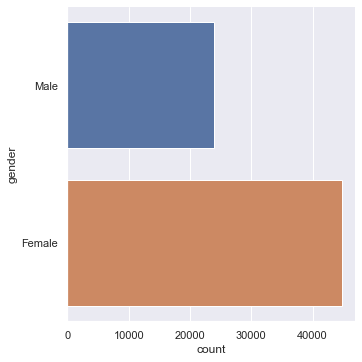

<Figure size 1728x288 with 0 Axes>

In [19]:
sb.catplot(y = 'gender', data = gender, kind = "count")
f = plt.figure(figsize = (24,4))

In [20]:
height = pd.DataFrame(int64_items["height"])
height.describe()

,height
count,68667.000000
mean,164.361178
std,8.183950
min,55.000000
25%,159.000000
50%,165.000000
75%,170.000000
max,250.000000


<AxesSubplot:>

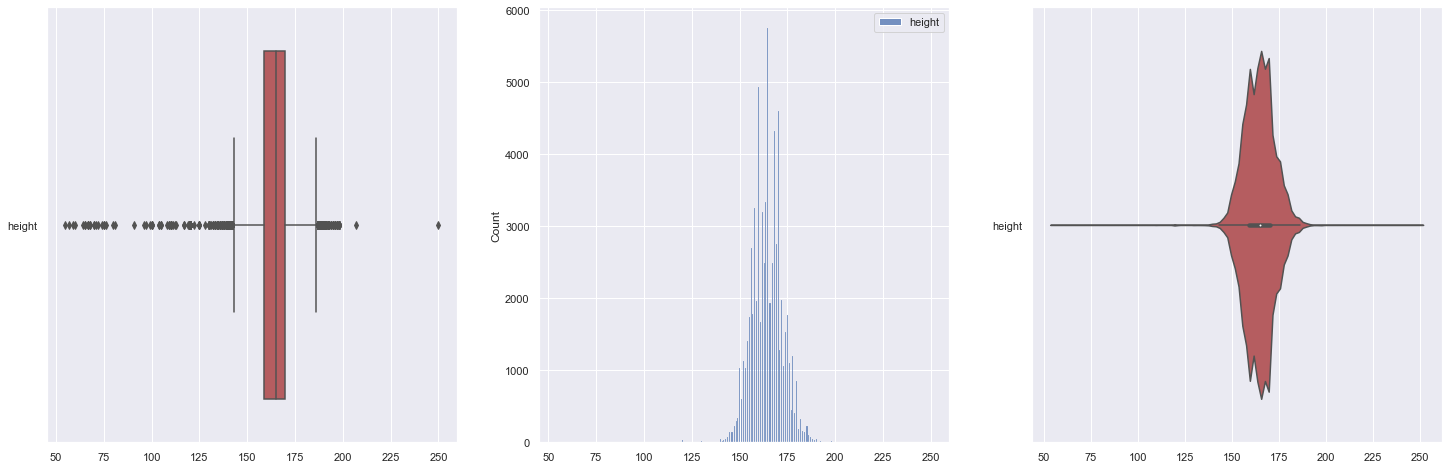

In [21]:
f, axes = plt.subplots(1, 3, figsize=(25, 8))
sb.boxplot(data = height, orient = "h", color = "r", ax = axes[0])
sb.histplot(data= height, color = "r", ax = axes[1])
sb.violinplot(data= height, orient='h', color = "r", ax = axes[2])

In [22]:
weight = pd.DataFrame(float64_items["weight"])
weight.describe()

,weight
count,68667.000000
mean,74.113220
std,14.323022
min,11.000000
25%,65.000000
50%,72.000000
75%,82.000000
max,200.000000


<AxesSubplot:>

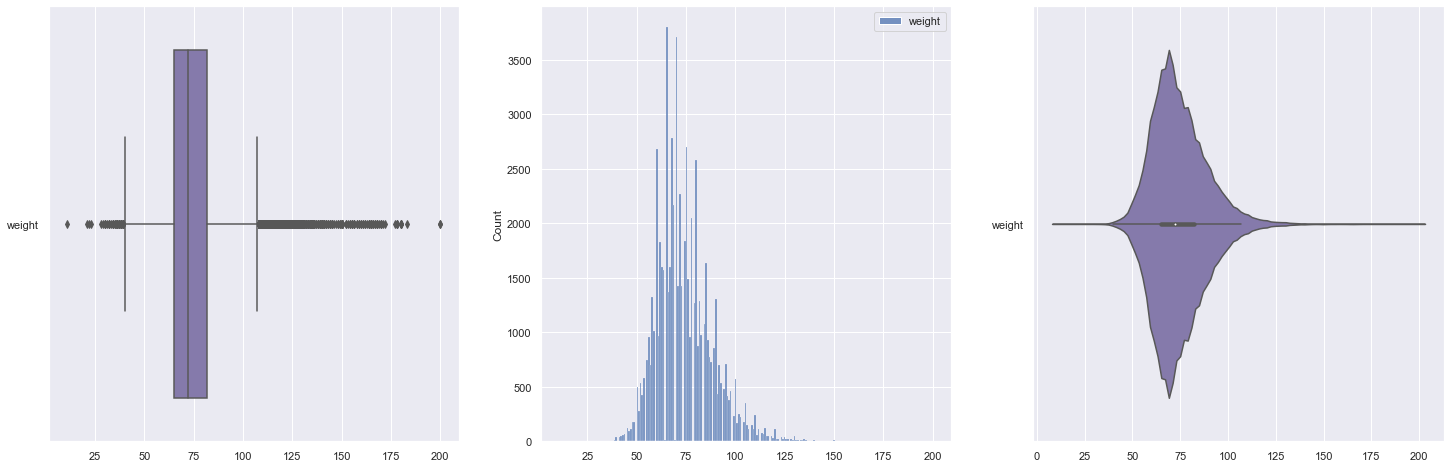

In [23]:
f, axes = plt.subplots(1, 3, figsize=(25, 8))
sb.boxplot(data = weight, orient = "h", color = "m", ax = axes[0])
sb.histplot(data= weight, color = "m", ax = axes[1])
sb.violinplot(data= weight, orient='h', color = "m", ax = axes[2])

# AP_HI is Systolic blood pressure

In [24]:
ap_hi = pd.DataFrame(int64_items["ap_hi"])
ap_hi.describe()

,ap_hi
count,68667.000000
mean,126.560546
std,16.536729
min,80.000000
25%,120.000000
50%,120.000000
75%,140.000000
max,200.000000


<AxesSubplot:>

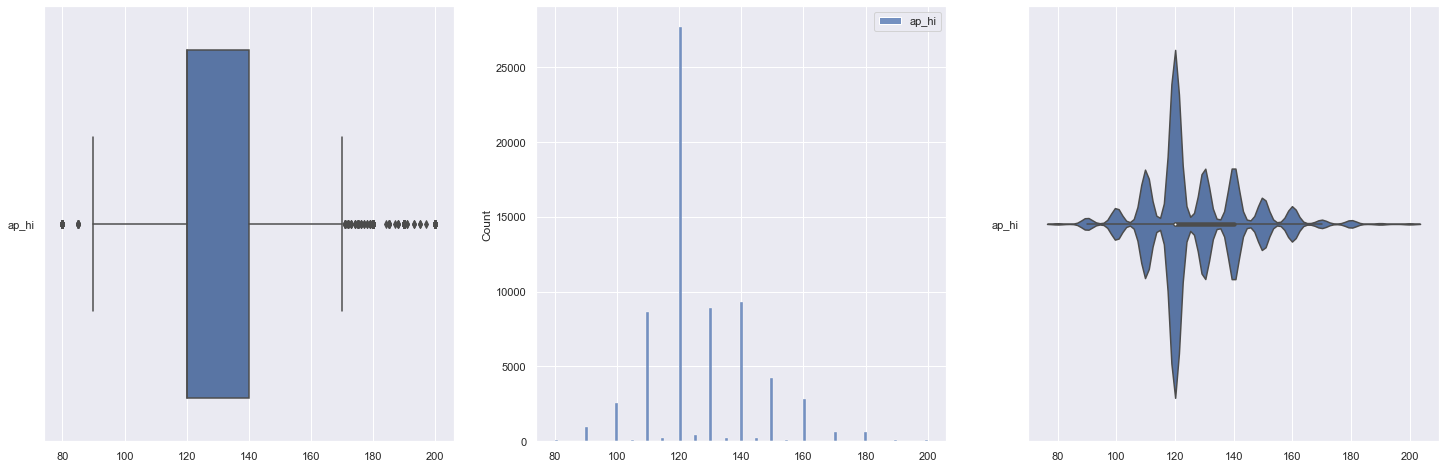

In [25]:
f, axes = plt.subplots(1, 3, figsize=(25, 8))
sb.boxplot(data = ap_hi, orient = "h", color = "b", ax = axes[0])
sb.histplot(data= ap_hi, color = "b", ax = axes[1])
sb.violinplot(data= ap_hi, orient='h', color = "b", ax = axes[2])

# AP_LO is Diastolic blood pressure 

In [26]:
ap_lo = pd.DataFrame(int64_items["ap_lo"])
ap_lo.describe()

,ap_lo
count,68667.000000
mean,81.328251
std,9.451296
min,45.000000
25%,80.000000
50%,80.000000
75%,90.000000
max,140.000000


<AxesSubplot:>

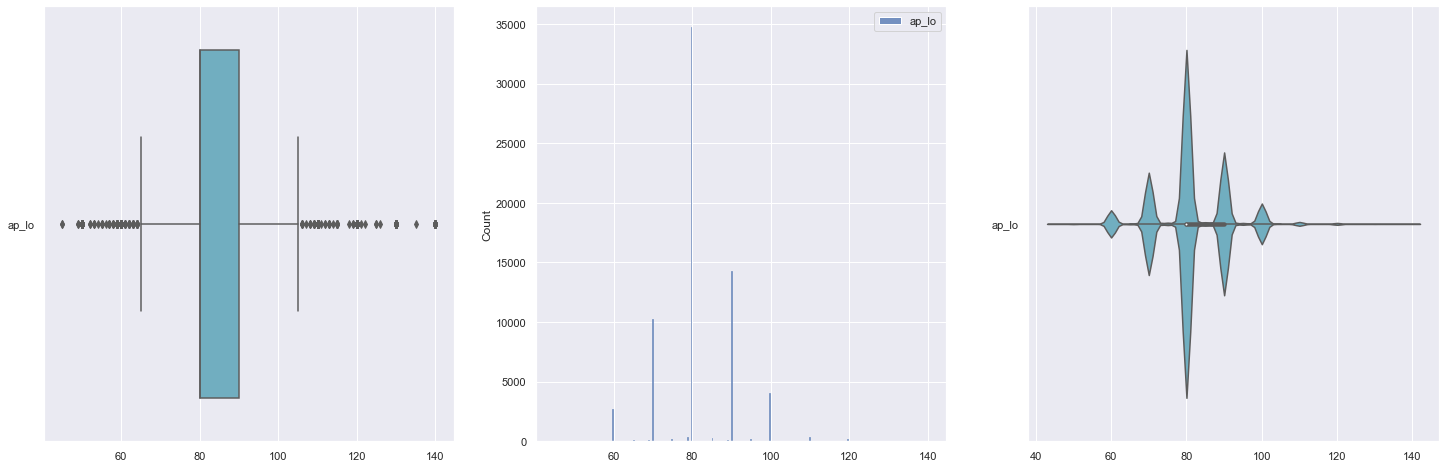

In [27]:
f, axes = plt.subplots(1, 3, figsize=(25, 8))
sb.boxplot(data = ap_lo, orient = "h", color = "c", ax = axes[0])
sb.histplot(data= ap_lo, color = "c", ax = axes[1])
sb.violinplot(data= ap_lo, orient='h', color = "c", ax = axes[2])

In [28]:
cholesterol = pd.DataFrame(int64_items["cholesterol"])
cholesterol.describe()

,cholesterol
count,68667.000000
mean,1.364396
std,0.678788
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,3.000000


In [29]:
cholesterol["cholesterol"] = cholesterol["cholesterol"].replace({1:'Normal', 2:"Above Normal", 3:"Well above normal"}) #Cleaning cholesterol dataset
cholesterol

,cholesterol
0,Normal
1,Well above normal
2,Well above normal
3,Normal
4,Normal
...,...
69995,Normal
69996,Above Normal
69997,Well above normal
69998,Normal


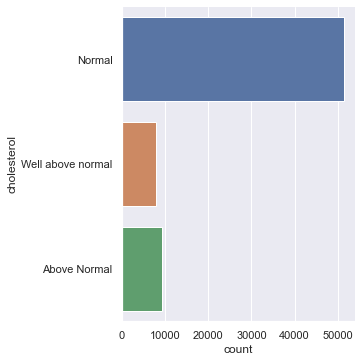

<Figure size 1728x288 with 0 Axes>

In [30]:
sb.catplot(y = 'cholesterol', data = cholesterol, kind = "count")
f = plt.figure(figsize = (24,4))

In [31]:
glucose = pd.DataFrame(int64_items["gluc"])
glucose.describe()

,gluc
count,68667.000000
mean,1.225712
std,0.571698
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,3.000000


In [32]:
glucose["gluc"] = glucose["gluc"].replace({1:'Normal', 2:"Above Normal", 3:"Well above normal"}) #Cleaning glucose dataset
glucose

,gluc
0,Normal
1,Normal
2,Normal
3,Normal
4,Normal
...,...
69995,Normal
69996,Above Normal
69997,Normal
69998,Above Normal


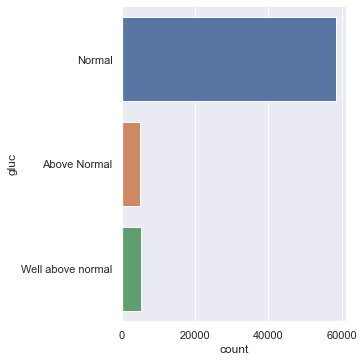

<Figure size 1728x288 with 0 Axes>

In [33]:
sb.catplot(y = 'gluc', data = glucose, kind = "count")
f = plt.figure(figsize = (24,4))

In [34]:
smoke = pd.DataFrame(int64_items["smoke"])
smoke.describe()

,smoke
count,68667.000000
mean,0.088004
std,0.283303
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [35]:
smoke["smoke"] = smoke["smoke"].replace({1:"Yes", 0:"No"}) #Cleaning smoke dataset
smoke

,smoke
0,No
1,No
2,No
3,No
4,No
...,...
69995,Yes
69996,No
69997,No
69998,No


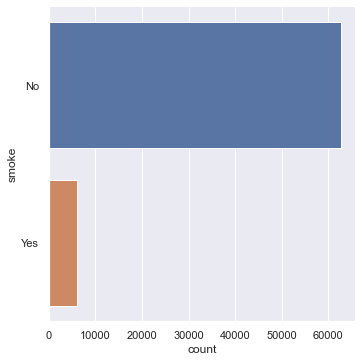

<Figure size 1728x288 with 0 Axes>

In [36]:
sb.catplot(y = 'smoke', data = smoke, kind = "count")
f = plt.figure(figsize = (24,4))

In [37]:
alcohol = pd.DataFrame(int64_items["alco"])
alcohol.describe()

,alco
count,68667.000000
mean,0.053505
std,0.225039
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [38]:
alcohol["alco"] = alcohol["alco"].replace({1:"Yes", 0:"No"}) #Cleaning alcohol dataset
alcohol

,alco
0,No
1,No
2,No
3,No
4,No
...,...
69995,No
69996,No
69997,Yes
69998,No


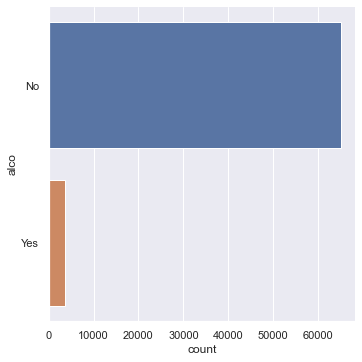

<Figure size 1728x288 with 0 Axes>

In [39]:
sb.catplot(y = 'alco', data = alcohol, kind = "count")
f = plt.figure(figsize = (24,4))

In [40]:
physical_Activity = pd.DataFrame(int64_items["active"])
physical_Activity.describe()

,active
count,68667.000000
mean,0.803428
std,0.397409
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [41]:
physical_Activity["active"] = physical_Activity["active"].replace({1:"Yes", 0:"No"}) #Cleaning physical activity dataset
physical_Activity

,active
0,Yes
1,Yes
2,No
3,Yes
4,No
...,...
69995,Yes
69996,Yes
69997,No
69998,No


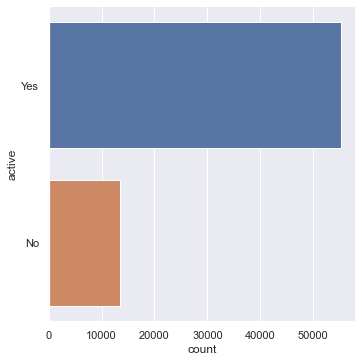

<Figure size 1728x288 with 0 Axes>

In [42]:
sb.catplot(y = 'active', data = physical_Activity, kind = "count")
f = plt.figure(figsize = (24,4))

In [43]:
cardio_Disease = pd.DataFrame(int64_items["cardio"])
cardio_Disease.describe()

,cardio
count,68667.000000
mean,0.494604
std,0.499975
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [44]:
cardio_Disease["cardio"] = cardio_Disease["cardio"].replace({1:"Yes", 0:"No"}) #Cleaning presence of cardiovascular disease dataset
cardio_Disease

,cardio
0,No
1,Yes
2,Yes
3,Yes
4,No
...,...
69995,No
69996,Yes
69997,Yes
69998,Yes


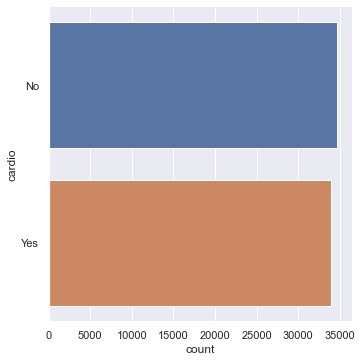

<Figure size 1728x288 with 0 Axes>

In [45]:
sb.catplot(y = 'cardio', data = cardio_Disease, kind = "count")
f = plt.figure(figsize = (24,4))